In [62]:
import numpy as np 
import matplotlib.pyplot as plt
from common import extract_log_data
from matplotlib.ticker import ScalarFormatter

plt.style.use('dark_background')

def get_best_epoch(epochs, validation_loss):
    min_val_loss = np.min(validation_loss).item()
    best_epoch = epochs[np.argmin(validation_loss)]
    return min_val_loss, best_epoch

def load_tp_fp_fn(exp_name):
    data = np.load(f"results/{exp_name}/tp_fp_fn.npz")
    tp_vec = data["tp"]
    fp_vec = data["fp"]
    fn_vec = data["fn"]
    return tp_vec, fp_vec, fn_vec

def compute_metrics(tp_vec, fp_vec, fn_vec):
    precision = tp_vec / (tp_vec + fp_vec)
    recall = tp_vec / (tp_vec + fn_vec)
    f1_score = tp_vec / (tp_vec + 0.5 * (fp_vec + fn_vec))
    return precision, recall, f1_score

In [48]:
checkpoint_folder = "checkpoints"

exp_name_v1 = "UNet2down_v9_Scos_adam_augv0_deterministic"
exp_name_v2 = "UNet2down_v9_Scos_adam_augv2_deterministic"

eps_v1, tr_loss_v1, val_loss_v1 = extract_log_data(f"{checkpoint_folder}/{exp_name_v1}.log")
eps_v2, tr_loss_v2, val_loss_v2 = extract_log_data(f"{checkpoint_folder}/{exp_name_v2}.log")

min_loss_v1, best_epoch_v1 = get_best_epoch(eps_v1, val_loss_v1)
min_loss_v2, best_epoch_v2 = get_best_epoch(eps_v2, val_loss_v2)

In [63]:
thr_vec = np.arange(0, 1, step=0.01)
tp_v1, fp_v1, fn_v1 = load_tp_fp_fn(exp_name_v1)
tp_v2, fp_v2, fn_v2 = load_tp_fp_fn(exp_name_v2)

precision_v1, recall_v1, f1_v1 = compute_metrics(tp_v1, fp_v1, fn_v1)
precision_v2, recall_v2, f1_v2 = compute_metrics(tp_v2, fp_v2, fn_v2)

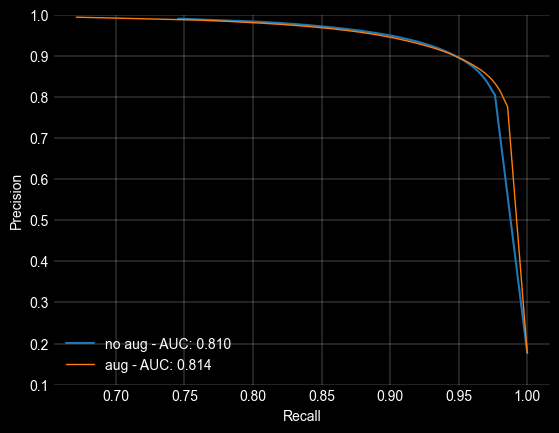

In [86]:
def auc_from_roc_curve(tp, fp, fn):
    tpr = tp / (tp[0] + fn[0])
    fpr = fp / (fp[0] + tp[0])
    sorted_indices = np.argsort(fpr)
    fpr = np.array(fpr)[sorted_indices]
    tpr = np.array(tpr)[sorted_indices]
    return np.trapezoid(tpr, fpr)

auc_v1 = auc_from_roc_curve(tp_v1, fp_v1, fn_v1)
auc_v2 = auc_from_roc_curve(tp_v2, fp_v2, fn_v2)

fig, ax = plt.subplots()
# ax.plot(thr_vec, f1_v1, '--', color='#1f77b4', label="no aug - precision")
# ax.plot(thr_vec, recall_v1, '-', color='#1f77b4', label="no aug - recall")
# ax.plot(thr_vec, f1_v2, '--', color='#ff7f0e', label="aug - precision")
# ax.plot(thr_vec, recall_v2, '-', color='#ff7f0e', label="aug - recall")
ax.plot(recall_v1, precision_v1, '-', color='#1f77b4', label=f"no aug - AUC: {auc_v1:.3f}", linewidth=1.5)
ax.plot(recall_v2, precision_v2, '-', color='#ff7f0e', label=f"aug - AUC: {auc_v2:.3f}", linewidth=1)
ax.grid(which="major", linestyle='-', linewidth=0.2)
ax.legend(loc='lower left')
ax.set_ylabel("Metric")
ax.set_xlabel("Threshold")
ax.set_ylabel("Precision")
ax.set_xlabel("Recall")
ax.set_ylim([0.1, 1])
plt.show()

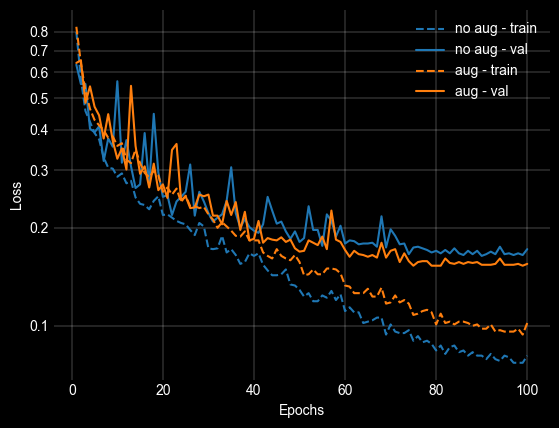

In [55]:
# from matplotlib.lines import Line2D

# custom_lines = [Line2D([0], [0], linestyle="-", lw=1),
#                 Line2D([0], [0], linestyle="--", lw=1)]

fig, ax = plt.subplots()
ax.plot(eps_v1, tr_loss_v1, '--', color='#1f77b4', label="no aug - train")
ax.plot(eps_v1, val_loss_v1, '-', color='#1f77b4', label="no aug - val")
ax.plot(eps_v2, tr_loss_v2, '--', color='#ff7f0e', label="aug - train")
ax.plot(eps_v2, val_loss_v2, '-', color='#ff7f0e', label="aug - val")
ax.grid(which="major", linestyle='-', linewidth=0.2)
ax.legend()
ax.set_ylabel("Loss")
ax.set_xlabel("Epochs")
ax.set_yscale("log")
ax.set_yticks(np.arange(0.1, 0.9, step=0.1))
ax.minorticks_off()
ax.yaxis.set_major_formatter(ScalarFormatter())
plt.show()